In [1]:
import pandas as pd 

df = pd.read_csv("master_f1_dataset_2025_test.csv")
df.head()

,Driver,fp2_avg_lap,fp2_best_lap,fp2_total_laps,FastestQualiLap,QualiPosition,RacePosition,DNF,grand_prix
0,ALB,92.966765,77.302,17,75.737,6,5,False,Australia
1,ALO,91.150048,77.330,21,76.288,12,21,True,Australia
2,ANT,85.246222,77.634,18,76.525,16,4,False,Australia
3,BOR,86.275188,77.847,16,76.516,15,21,True,Australia
4,DOO,91.787609,77.394,23,76.315,13,21,True,Australia


In [2]:
df["is_podium_finish"] = df["RacePosition"] <= 3
print(df["is_podium_finish"].value_counts())

is_podium_finish
False    198
True      36
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["RacePosition", "DNF", "grand_prix", "is_podium_finish", "Driver"])
y = df["is_podium_finish"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

In [4]:
print(X.columns)
print(X.dtypes)

Index(['fp2_avg_lap', 'fp2_best_lap', 'fp2_total_laps', 'FastestQualiLap',
       'QualiPosition'],
      dtype='object')
fp2_avg_lap        float64
fp2_best_lap       float64
fp2_total_laps       int64
FastestQualiLap    float64
QualiPosition        int64
dtype: object


              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



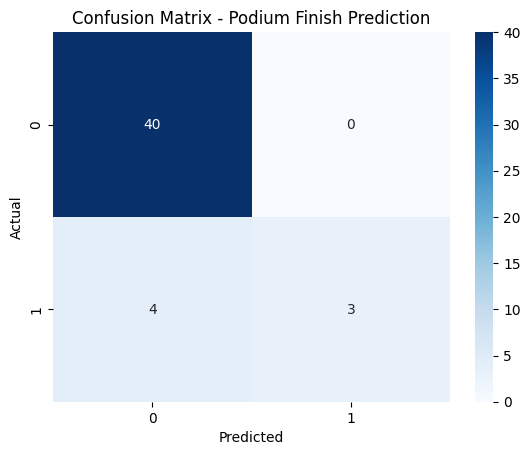

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt 

model = RandomForestClassifier(random_state=22)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Podium Finish Prediction")
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(class_weight='balanced', random_state=22)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print(classification_report(y_test, y_pred_log))
confusion_matrix(y_test, y_pred_log)

              precision    recall  f1-score   support

       False       1.00      0.85      0.92        40
        True       0.54      1.00      0.70         7

    accuracy                           0.87        47
   macro avg       0.77      0.93      0.81        47
weighted avg       0.93      0.87      0.89        47



array([[34,  6],
       [ 0,  7]])

Gradient Boosting Results:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



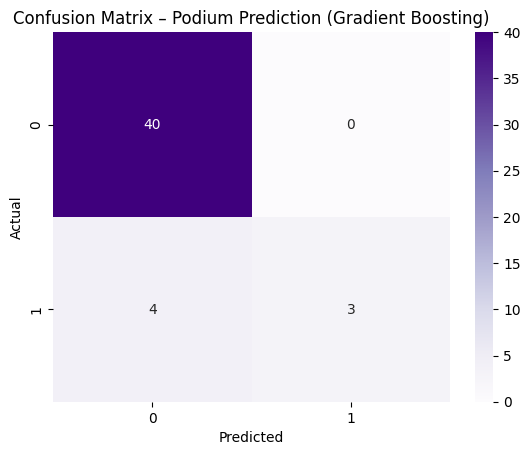

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the model
gb_model = GradientBoostingClassifier(random_state=22)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Print evaluation metrics
print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Podium Prediction (Gradient Boosting)")
plt.show()